In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


import geopandas as gp
import pycountry

import sys

sys.path.insert(0, "../Notebooks/Functions")
import StatsFunctions as MF

In [2]:
DF = pd.read_csv("../Data/avgIQpercountry.csv")

In [4]:
#Renamed for easier access
DF.rename(
    {
        "Average IQ": "IQ",
        "Literacy Rate": "Literacy",
        "Nobel Prices": "Nobels",
        "HDI (2021)": "HDI",
        "Mean years of schooling - 2021": "SchoolYears",
        " GNI - 2021": "GNI",
        "Population - 2023": "Population",
    },
    axis=1,
    inplace=True,
)

In [5]:
DF = DF.astype({"Population": "float64"})

In [109]:
order = DF["Country"].copy().to_list()
colours = dict(zip(DF["Continent"].unique(), sns.color_palette("Dark2")))
kwargs = {"hue": "Continent", "palette": colours, "edgecolor": "black", "alpha": 0.6}
# At a very late stage made a colour pallete for continents only

In [7]:
DF.dropna(how='any', inplace=True)

In [36]:
DF["Continent"].unique()

array(['Asia', 'Europe', 'North America', 'Oceania', 'Europe/Asia',
       'Central America', 'South America', 'Africa'], dtype=object)

In [8]:
#wanted to see if group by will be useful, but seaborn does it for me already
Continents = DF.groupby("Continent").agg(
    {"Literacy": MF.mean, "Population": "sum", "Nobels": "sum"}
)

In [9]:
#Thought might use later
less_10 = (
    DF.query("Population < 10000000")
    .groupby("Continent")
    .agg({"Literacy": MF.mean, "Population": "sum", "Nobels": "sum"})
    .sum()
)
over_10 = (
    DF.query("Population > 10000000")
    .groupby("Continent")
    .agg({"Literacy": MF.mean, "Population": "sum", "Nobels": "sum"})
)

In [38]:

#Not significant
fig = px.sunburst(
    DF.query("Population > 50_000_000"),
    path=["Continent", "Country"],
    values="Population",
    width=1000,
    height=600,
    title="Countries by population",
)
fig.show()

In [11]:
def heatmap(data, title=""):
    corr = data.corr()
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(corr, cmap="coolwarm", vmin=-1, vmax=1)
    fig.colorbar(cax)
    ticks = np.arange(0, len(corr.columns), 1)
    ax.set_xticks(ticks)
    plt.xticks(rotation=45)
    ax.set_yticks(ticks)
    ax.set_xticklabels(corr.columns)
    ax.set_yticklabels(corr.columns)

    matrix = pd.DataFrame(data.corr(method="pearson")).round(2)
    
    for i in range(len(matrix)):
        for j in range(len(matrix.iloc[0])):
            text = ax.text(j, i, matrix.iloc[i, j], ha="center", va="center", color="w")
    ax.set_title(title, pad=20)


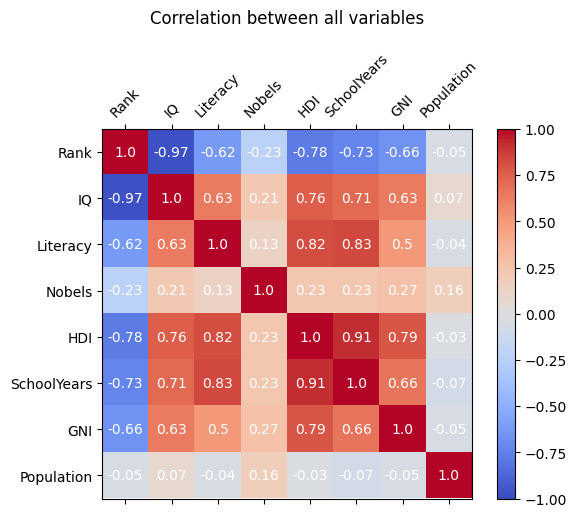

In [92]:
heatmap(
    DF.select_dtypes(include=np.number),
    title="Correlation between all variables",
)

Text(0.5, 1.0, 'Distribution of average IQ')

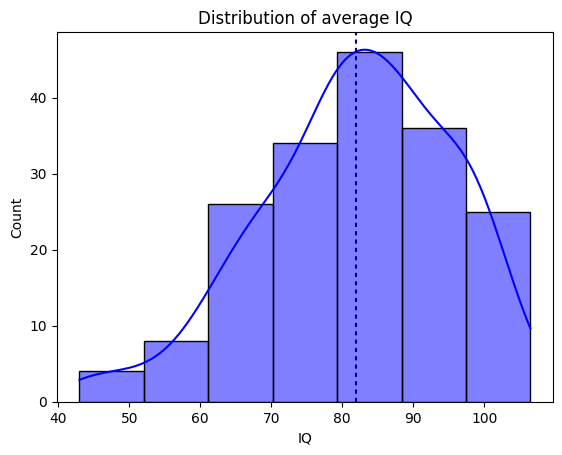

In [94]:
# decided to check average IQ and see how useful it would be
histIQ = sns.histplot(DF, x="IQ", bins=7, kde=True, color="blue")

plt.axvline(
    MF.mean(DF["IQ"]), color="darkblue", label="mean", dashes=(2, 2)
)  # TK change mean to my function

plt.title("Distribution of average IQ")

In [15]:
# #Won't go in final, just to see quickly if I can use something
# sns.pairplot(
#     DF[
#         [
#             "IQ",
#             "Literacy",
#             "Nobels",
#             "HDI",
#             "Continent",
#             "SchoolYears",
#             "GNI",
#         ]
#     ],
#     hue = "Continent"
    
# )

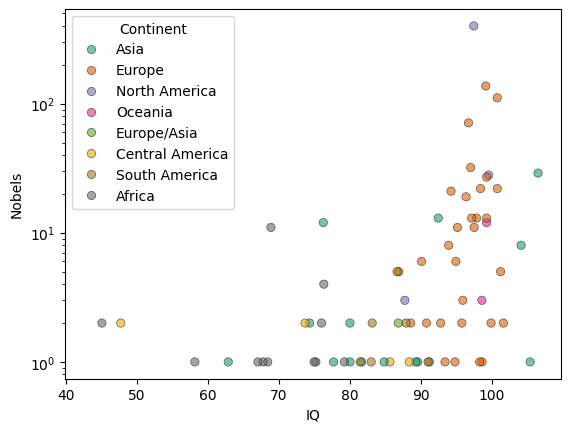

In [113]:
# Desided exprlore correlation between average IQ of a country with how many novel prises the continent won.
# Europe is on average smarter and have more entries due to more countries, but America is a clear outlier
# sns.scatterplot(data=DF, x="IQ", y="Nobels", hue="Continent", palette=colours, edgecolor = "black", alpha = 0.5)
sns.scatterplot(data=DF, x="IQ", y="Nobels", **kwargs)

plt.yscale("log")

Text(0.5, 1.0, 'Distribution of IQ for each continent')

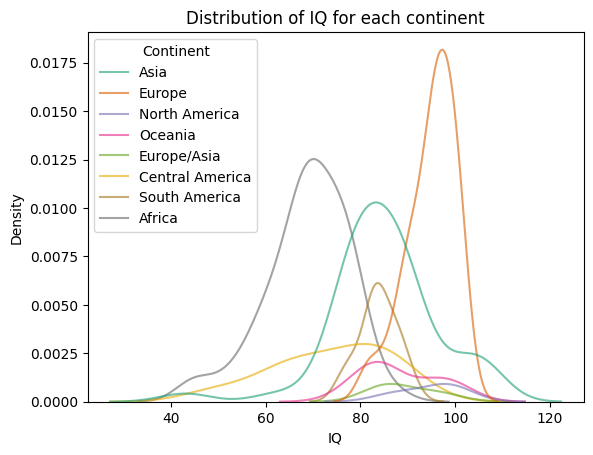

In [110]:
sns.kdeplot(data=DF, x="IQ", **{i:kwargs[i] for i in kwargs if i!='edgecolor'})
plt.title("Distribution of IQ for each continent")

Text(0.5, 0.98, 'Relationship between HDI and GNI in both linear and logarithmic scales')

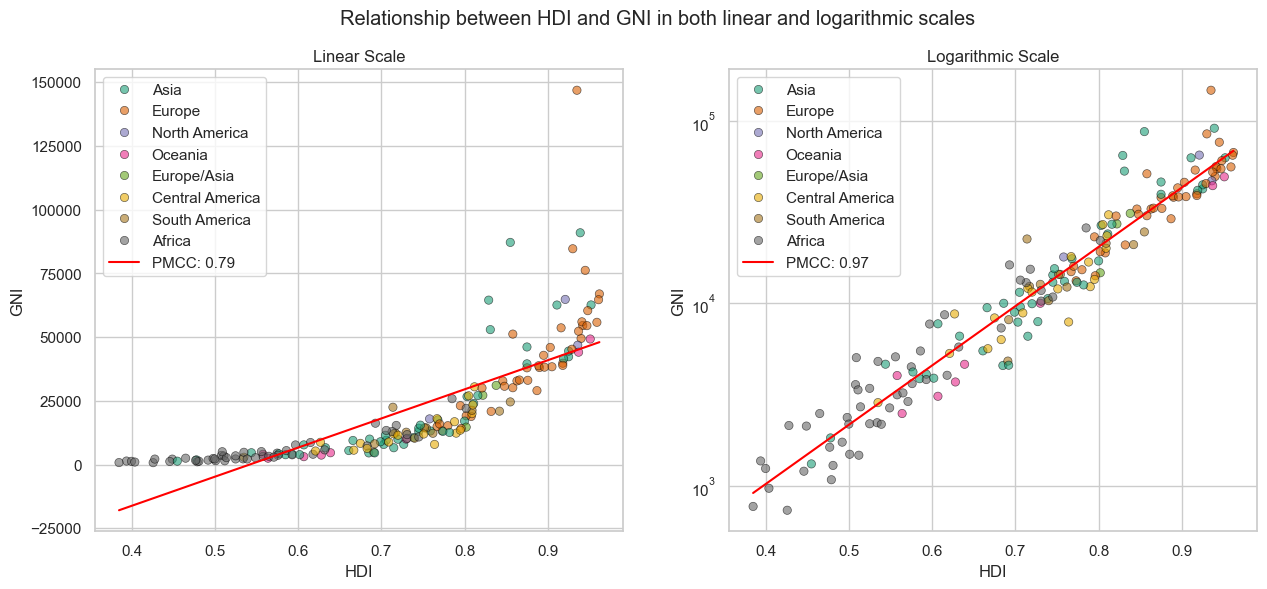

In [227]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
m,q, cor = MF.linear_regression(DF["HDI"].to_list(), DF["GNI"].to_list())
m1,q1, cor1 = MF.linear_regression(DF["HDI"].to_list(), np.log10(DF["GNI"].to_list()))
sns.scatterplot(data=DF, y="GNI", x="HDI", **kwargs, ax = axes[0])  
sns.lineplot(x = DF["HDI"], y = m*DF["HDI"] + q , label = f'PMCC: {round(cor, 2)}', color = "red", ax = axes[0])
axes[0].set_title("Linear Scale")

###
axes[1].set_yscale('log')
X = np.column_stack((np.ones_like(DF["HDI"]), DF["HDI"]))
y_log = np.log(DF["GNI"])
theta = np.linalg.inv(X.T @ X) @ X.T @ y_log
# Predict y values using the linear regression model
y_pred_log = X @ theta

# Plot the linear regression line
sns.scatterplot(data=DF, y="GNI", x="HDI", **kwargs, ax = axes[1])  
sns.lineplot(x = DF["HDI"], y = np.exp(y_pred_log) , label = f'PMCC: {round(cor1, 2)}', color = "red", ax = axes[1])
axes[1].set_title("Logarithmic Scale")

fig.suptitle('Relationship between HDI and GNI in both linear and logarithmic scales')



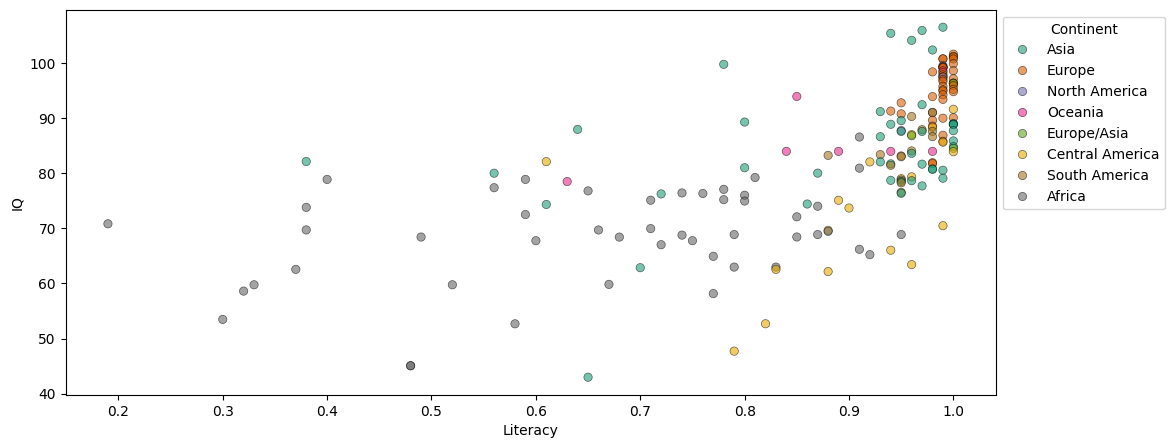

In [114]:
fig, ax = plt.subplots(figsize = (12,5))
sns.scatterplot(data=DF, y="IQ", x="Literacy", **kwargs)  #
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))


Text(0.5, 1.0, 'Distribution of IQ accross continents')

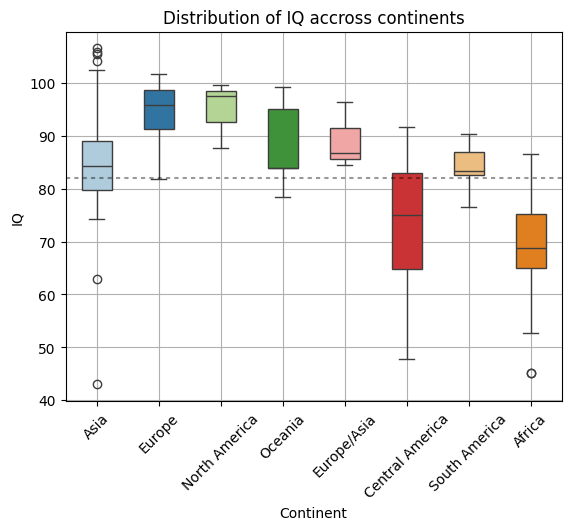

In [77]:
ax = sns.boxplot(
    data=DF,
    y="IQ",
    x="Continent",
    gap=0.4,
    **{i: kwargs[i] for i in kwargs if i not in ["edgecolor", "alpha"]},
    legend="auto"
)
plt.axhline(
    y=MF.mean(DF["IQ"]),
    color="black",
    alpha = 0.4,
    dashes=(2, 2),
)
ax.grid()
ax.tick_params(axis="x", rotation=45)

plt.title("Distribution of IQ accross continents")

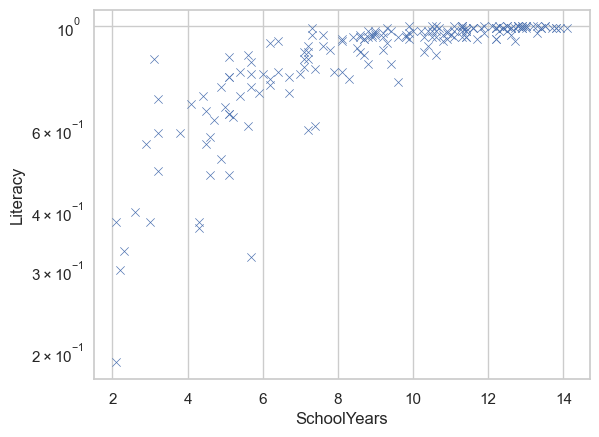

In [253]:
sns.scatterplot(DF, x = "SchoolYears", y = "Literacy", marker="x") #TK: come up with own funciton???
plt.yscale("log")

Text(0.5, 1.0, 'Correlation between years spent in school and literacy rate')

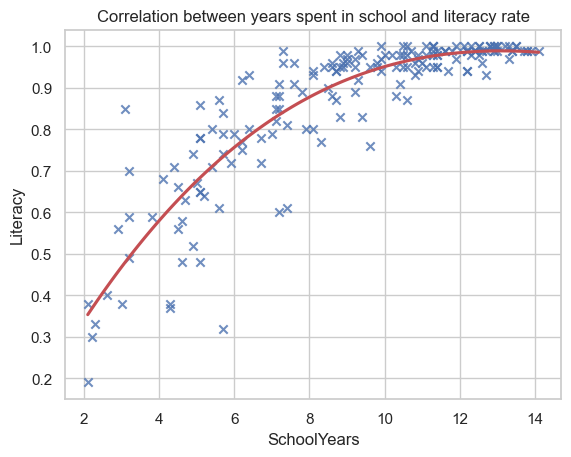

In [252]:
fig, ax = plt.subplots()
sns.regplot(DF, x = "SchoolYears", y = "Literacy", order=3, ci=0, marker="x", line_kws=dict(color="r")) #TK: come up with own funciton???
plt.title("Correlation between years spent in school and literacy rate") #dimitris discuss

In [22]:
world = gp.read_file(gp.datasets.get_path('naturalearth_lowres'))

C:\Users\dima1\AppData\Local\Temp\ipykernel_9892\20647279.py:1: FutureWarning:

The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.



In [23]:
rank_location = DF[::]

world = gp.read_file(gp.datasets.get_path('naturalearth_lowres'))
rank_location['ISO_alpha'] = rank_location['Country'].apply(lambda x: pycountry.countries.get(name=x).alpha_3 if pycountry.countries.get(name=x) else None)



C:\Users\dima1\AppData\Local\Temp\ipykernel_9892\1021141429.py:3: FutureWarning:

The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.

C:\Users\dima1\AppData\Local\Temp\ipykernel_9892\1021141429.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [24]:
fig = px.choropleth(
    rank_location.merge(world[["name", "geometry", "iso_a3"]], left_on="Country", right_on = "name", how = "left"),
    locations='iso_a3',
    color='SchoolYears',
    color_continuous_scale='YlOrRd',

    
)
fig.update_layout(margin={"r":0,"t":50,"l":0,"b":0})
fig.update_layout(title_text='Average length of schooling in countries', title_x=0.5, autosize = True)


fig.show()

In [25]:
fig = px.choropleth(
    rank_location.merge(world[["name", "geometry", "iso_a3"]], left_on="Country", right_on = "name", how = "left"),
    locations='iso_a3',
    color='Literacy',
    color_continuous_scale='YlOrRd',

    
)
fig.update_layout(margin={"r":0,"t":50,"l":0,"b":0})
fig.update_layout(title_text='Average literacy index of schooling in countries', title_x=0.5, autosize = True)


fig.show()

In [26]:
fig = px.choropleth(
    rank_location.merge(world[["name", "geometry", "iso_a3"]], left_on="Country", right_on = "name", how = "left"),
    locations='iso_a3',
    color='HDI',
    color_continuous_scale='YlOrRd',

    
)
fig.update_layout(margin={"r":0,"t":50,"l":0,"b":0})
fig.update_layout(title_text='HDI index of schooling in countries', title_x=0.5, autosize = True)


fig.show()

Text(0.5, 1.0, 'Most populated counties')

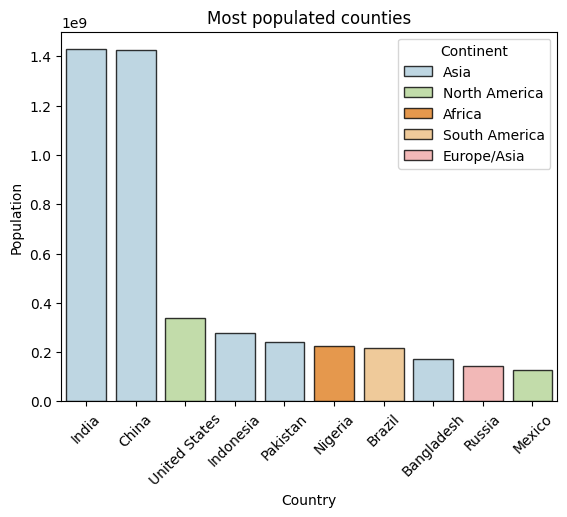

In [28]:
sns.barplot(DF.sort_values(by = "Population", ascending=False).head(10), x= "Country", y = "Population", **kwargs)
plt.xticks(rotation = 45)
plt.title("Most populated counties") #TK - not significant

Text(0.5, 1.0, 'Correlation between HDI and IQ for each country')

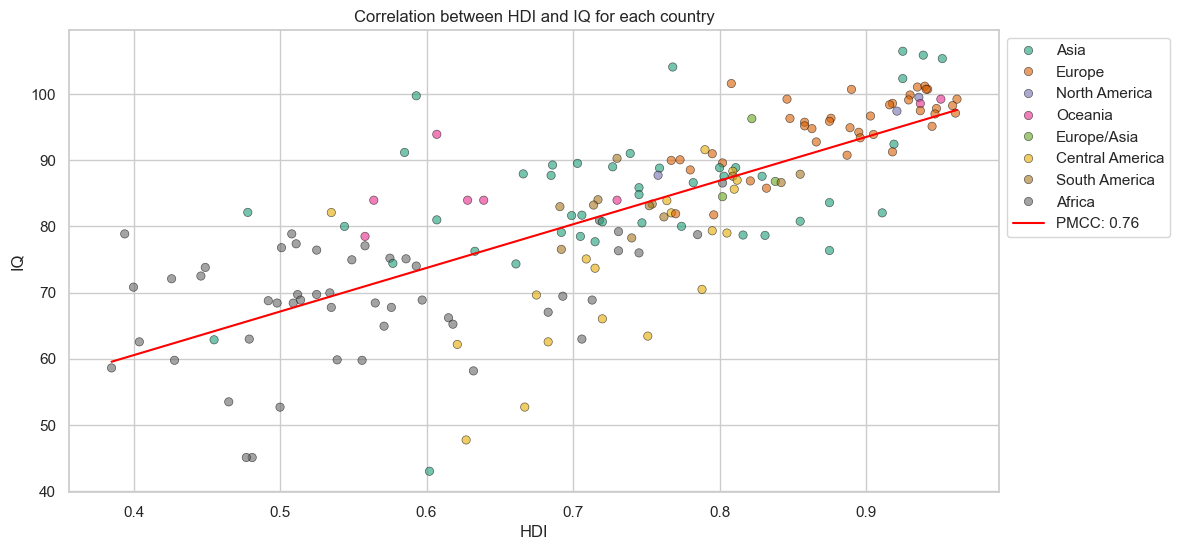

In [228]:
m,q, cor = MF.linear_regression(DF["HDI"].to_list(), DF["IQ"].to_list())

fig, ax = plt.subplots(figsize = (12,6))
sns.scatterplot(data = DF, x = "HDI", y = "IQ", **kwargs)
sns.lineplot(x = DF["HDI"], y = m * DF["HDI"] + q, label = f'PMCC: {round(cor, 2)}', color = "red")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title("Correlation between HDI and IQ for each country")


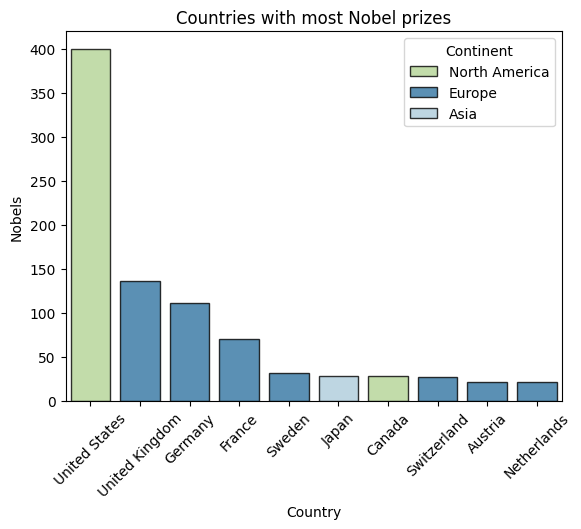

In [32]:
sns.barplot(DF.query("Nobels > 0").sort_values(by  = "Nobels", ascending=False).head(10), x = "Country", y = "Nobels",**kwargs)
plt.xticks(rotation = 45)
plt.title("Countries with most Nobel prizes")
plt.show()

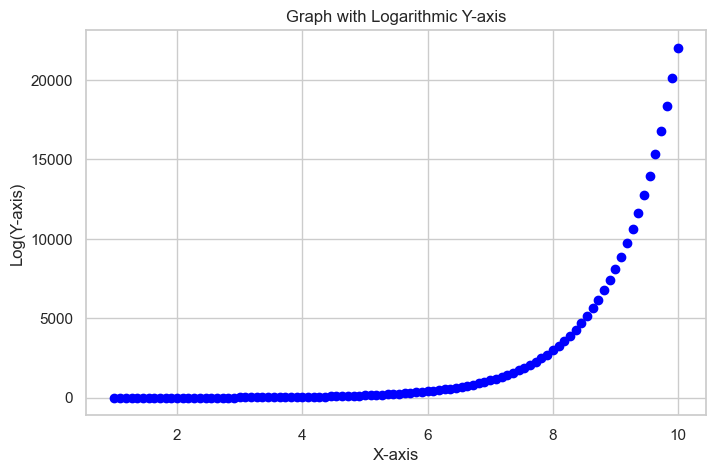

In [256]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data
x = np.linspace(1, 10, 100)
y_log = np.exp(x)  # Simulating a logarithmic relationship

# Create a plot with a logarithmic y-axis
plt.figure(figsize=(8, 5))
plt.scatter(x, y_log, label='Original Data', color='blue')
plt.yscale('log')  # Set y-axis to log scale

# Set labels and title
plt.xlabel('X-axis')
plt.ylabel('Log(Y-axis)')
plt.title('Graph with Logarithmic Y-axis')

plt.show()


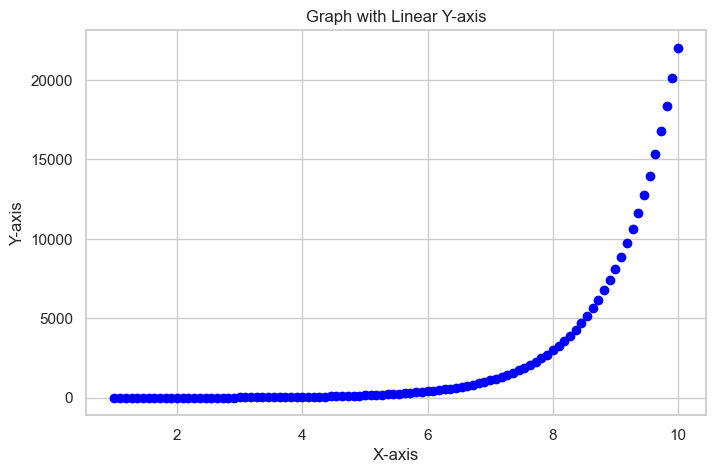

In [255]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data
x = np.linspace(1, 10, 100)
y_log = np.exp(x)  # Simulating a logarithmic relationship

# Create a plot with a linear y-axis
plt.figure(figsize=(8, 5))
plt.scatter(x, y_log, label='Original Data', color='blue')

# Set labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Graph with Linear Y-axis')

plt.show()
